# Vanilla RNN classification
Twitter sentiment analysis using Vanilla RNN.

This covers for Vanilla, GRU and LSTM variant.

No much twearking to be done, when switching between variants of RNN's

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import time
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data Preprocessing

In [3]:
column_names = ['ID', 'Game', 'Sentiment', 'Text']

train = pd.read_csv('/content/drive/MyDrive/DSN/class_3/data/twitter_training.csv', names=column_names)[['Text', 'Sentiment']]
test = pd.read_csv('/content/drive/MyDrive/DSN/class_3/data/twitter_validation.csv', names=column_names)[['Text', 'Sentiment']]

train['Sentiment'] = train['Sentiment'].map({'Negative': 0, 'Positive': 1, 'Neutral': 2, 'Irrelevant': 3})
test['Sentiment'] = test['Sentiment'].map({'Negative': 0, 'Positive': 1, 'Neutral': 2, 'Irrelevant': 3})

train.drop_duplicates(subset=['Text'], inplace=True)
test.drop_duplicates(subset=['Text'], inplace=True)

train.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)


def str_lower(text):
    return text.lower()

train['Text'] = train['Text'].apply(str_lower)
test['Text'] = test['Text'].apply(str_lower)


# train = train.iloc[:5000, :]
# test = test.iloc[:999, :]

del column_names
train.shape, test.shape

((69491, 2), (999, 2))

# Further text preprocessing

- vocabulary
- tokenization

In [4]:
vocab = set()
for text in train['Text'].tolist():
    vocab.update(text.split())
vocab = sorted(list(vocab))

word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

In [5]:
MAX_SEQ_LENGTH = 50

def tokenize_and_pad(text, max_length):
    tokens = text.split()
    token_ids = [word2idx.get(word, 0) for word in tokens]  # 0 for unknown words

    # pad or truncate to fixed length
    if len(token_ids) > max_length:
        token_ids = token_ids[:max_length]
    else:
        token_ids = token_ids + [0] * (max_length - len(token_ids))

    return token_ids


X_train = np.array([tokenize_and_pad(text, MAX_SEQ_LENGTH) for text in train['Text']])
y_train = train['Sentiment'].values

X_test = np.array([tokenize_and_pad(text, MAX_SEQ_LENGTH) for text in test['Text']])
y_test = test['Sentiment'].values

### Dataset

In [6]:
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

### DataLoader

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Building the Network

In [8]:
class RNNWithEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, rnn_type='vanilla'):
        super(RNNWithEmbedding, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        if rnn_type.lower() == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
            self.uses_lstm = True
        elif rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_size, batch_first=True)
            self.uses_lstm = False
        else:
            self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
            self.uses_lstm = False

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]

        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)

        if self.uses_lstm:
            c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
            out, _ = self.rnn(embedded, (h0, c0))
        else:
            out, _ = self.rnn(embedded, h0)

        out = self.fc(out[:, -1, :])  # using the last hidden state
        return out

In [9]:
vocab_size = len(vocab) + 1  # +1 for padding/unknown tokens
embedding_dim = 1000
hidden_size = 512
output_size = 4  # number of outcome to predict
rnn_type = 'lstm'  # 'vanilla', 'lstm', 'gru'

model = RNNWithEmbedding(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    output_size=output_size,
    rnn_type=rnn_type
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_true)) * 100
    return acc

### Training

In [11]:
def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              criterion: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):

  train_loss, train_acc = 0, 0

  model.train()

  for batch, (inputs, labels) in enumerate(data_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss = loss.item()
    train_acc += accuracy_fn(labels, outputs.argmax(dim=1))

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f'Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%')

  return train_loss, train_acc

In [12]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              criterion: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X = X.to(device)
      y = y.to(device)

      pred = model(X)

      test_loss += criterion(pred.squeeze(), y).item()
      test_acc += accuracy_fn(y, pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
  return test_loss, test_acc

In [13]:
epochs = 7
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-------------------')
    train_loss, train_acc = train_step(
        model = model,
        data_loader = train_dataloader,
        criterion = criterion,
        optimizer = optimizer ,
        accuracy_fn = accuracy_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    test_loss, test_acc = test_step(
        data_loader = test_dataloader,
        model = model,
        criterion = criterion,
        accuracy_fn = accuracy_fn)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0
-------------------
Train loss: 0.00173 | Train accuracy: 48.07%
Test loss: 0.81799 | Test accuracy: 69.97%

Epoch: 1
-------------------
Train loss: 0.00100 | Train accuracy: 75.63%
Test loss: 0.32742 | Test accuracy: 90.46%

Epoch: 2
-------------------
Train loss: 0.00041 | Train accuracy: 92.02%
Test loss: 0.16592 | Test accuracy: 95.61%

Epoch: 3
-------------------
Train loss: 0.00033 | Train accuracy: 96.90%
Test loss: 0.16845 | Test accuracy: 95.49%

Epoch: 4
-------------------
Train loss: 0.00002 | Train accuracy: 98.29%
Test loss: 0.16010 | Test accuracy: 96.10%

Epoch: 5
-------------------
Train loss: 0.00029 | Train accuracy: 98.79%
Test loss: 0.18489 | Test accuracy: 95.22%

Epoch: 6
-------------------
Train loss: 0.00013 | Train accuracy: 98.84%
Test loss: 0.19163 | Test accuracy: 95.46%



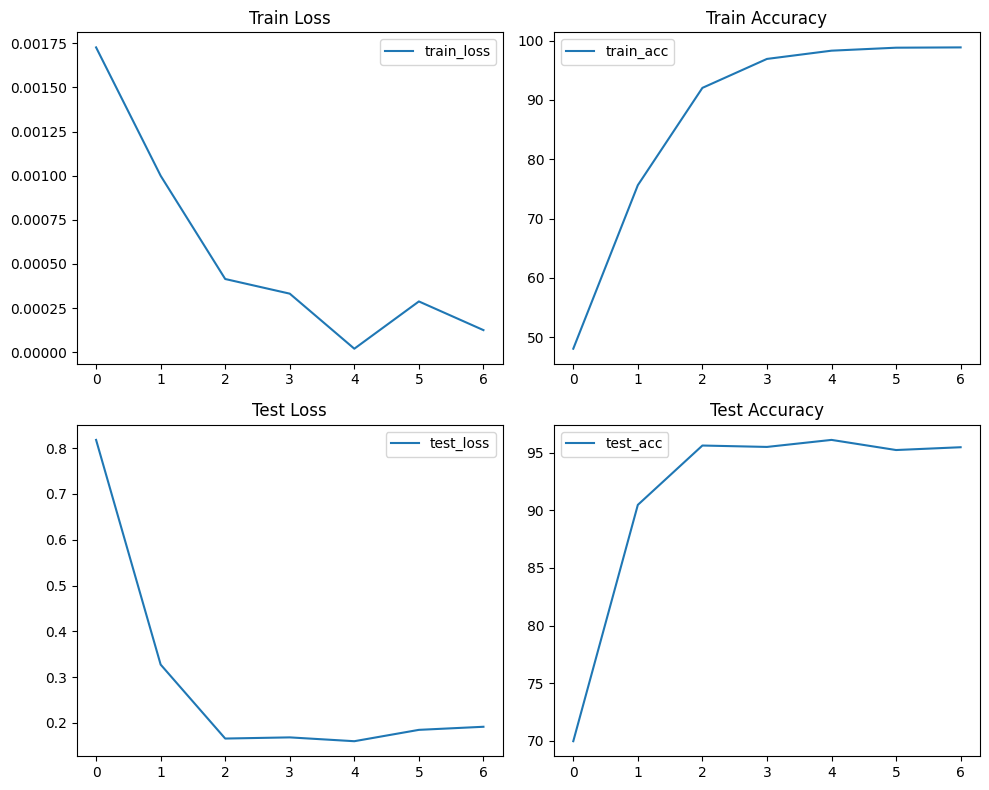

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(train_loss_list, label='train_loss')
axes[0, 0].set_title('Train Loss')
axes[0, 0].legend()

axes[0, 1].plot(train_acc_list, label='train_acc')
axes[0, 1].set_title('Train Accuracy')
axes[0, 1].legend()

axes[1, 0].plot(test_loss_list, label='test_loss')
axes[1, 0].set_title('Test Loss')
axes[1, 0].legend()

axes[1, 1].plot(test_acc_list, label='test_acc')
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].legend()

plt.tight_layout()

plt.show()